<a href="https://colab.research.google.com/github/Shahabshms/Bethe-Free-Energy-approximation-of-the-Homomorphims-number/blob/main/Bethe_Free_Energy_approximation_of_the_Homomorphims_number_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import random
from itertools import permutations
import numpy.matlib


from progressbar import ProgressBar
pbar = ProgressBar()
import math

 ## homomorphism

Given bipartite a graph $G = (A_G,B_G,E_G)$, and a matrix $M \in \mathbb{R}^{m\times m}$,

The actual homomorphism number from vertices of $G$ to matrix $M$ is defined
$$\text{hom}(G,M) = \sum_{X \in [m]^{|V_G|}} \prod_{\substack{(i,j)\in E_G\\i\in A_G, j\in B_G}} M_{x_i,x_j}.$$

In [2]:
# Actual value
def hom(G,M):  # G : networkx graph object. M : numpy square matrix
  v = len(G.nodes())
  m = M.shape[0]

  hom = 0
  for i in range(m**v):
    assignments = [-1 for k in range(v)]
    for j in range(v):
      assignments[j] = i%m
      i = i//m
    
    mul_temp = 1
    for e in G.edges():
      mul_temp *= M[assignments[e[0]],assignments[e[1]]] 

    # print(assignments,'   ',mul_temp)
    hom += mul_temp

  return hom

Bethe Free Energy approximation of $\text{hom}(G,M)$ is defined:
\begin{align}
Z = \max_{\tau \in T}\Bigg(&- \sum_{i\in V} \sum_{x_i} \tau_i(x_i) \log(\tau_i(x_i)) - \sum_{C} \sum_{x_C} \tau_C(x_C)\log(\frac{\tau_{C}(x_C)}{\prod_{i\in C} \tau_i(x_i)})\\
& + \sum_{C} \sum_{x_C}\tau_{C}(x_C)\log(\psi_C(x_C))+ \sum_{i\in V} \sum_{x_i}\tau_{i}(x_i)\log(\psi_i(x_i))\Bigg),
\end{align}


$$\text{hom}_{\text{B}}(G,M) = \exp(Z).$$

In [3]:
# The Bethe Approximation of the homomorphism number.
def homb(G,M): # G is nx graph. M is np square matrix

  G = initial_G(G,M)
  # Fixed points of loopy belief propagation correspond to
  # saddle points of this objective over the local marginal polytope
  G = set_believes(G,message_passing(G,10)) 

  sum_1_H = 0
  sum_2_H = 0
  sum_3_U = 0
  sum_4_U = 0 

  for i in G.nodes.values():
    for xi in range(len(i.p_func)):
      sum_1_H += math.log( i.b[xi] ** i.b[xi] )
      sum_4_U += math.log( i.p_func[xi] ** i.b[xi] )

  for (i,j) in G.edges.keys():
    for xi in range(len(G.nodes[i].p_func)):
      for xj in range(len(G.nodes[j].p_func)):

        prodd = G.nodes[i].b[xi] * G.nodes[j].b[xj]

        sum_2_H += math.log( (G.edges[(i,j)].b[(xi,xj)] / prodd) ** G.edges[(i,j)].b[(xi,xj)])
        sum_3_U += math.log( (G.edges[(i,j)].p_func[(xi,xj)]) ** G.edges[(i,j)].b[(xi,xj)])

  H = - sum_1_H - sum_2_H # Entropy
  U = sum_3_U + sum_4_U # Energy
  return  np.exp( H + U )

In [ ]:
# The kth order approximation of homomorphism number
# Based on Vontoble's Theorem.
# def hom_T(G,M,k):

### Belief Propagation

In [4]:
class node:
  def __init__(self,index):
    self.index = index
    self.p_func = None
    self.edges = None
    self.b = None

class edge:
  def __init__(self,ends):
    self.ends = ends
    self.p_func = None
    self.b = None

class graph:
  def __init__(self):
    self.nx_object = None
    self.nodes = None
    self.edges = None

def messages(G,coef = 1):
  m = {}
  for (v1,v2) in G.nx_object.edges:
    m[(v1,v2)] = coef * np.ones(len(G.nodes[v1].p_func))
    if np.sum(m[(v1,v2)]) != 0:
      m[(v1,v2)] = m[(v1,v2)] / np.sum(m[(v1,v2)])

    m[(v2,v1)] = coef * np.ones(len(G.nodes[v2].p_func))
    if np.sum(m[(v2,v1)]) != 0:
      m[(v2,v1)] = m[(v2,v1)] / np.sum(m[(v2,v1)])

  return m

In this particular task of approximating homomorphism number,
$$ \forall (i,j)\in E_G, \psi_{i,j} = M$$
and 
$$ \forall i\in V_G, \phi_i(\cdot) = 1.$$


In [5]:
def initial_G(G,M):  # G is nx object. M is np square matrix

  m = M.shape[0]

  nodes = {}
  edges = {}

  for e in G.edges:
    an_edge = edge(e)
    an_edge.p_func = M
    edges[e] = an_edge

  for n in G.nodes:
    a_node = node(n)
    a_node.p_func = np.ones(m)
    a_node.edges = G.edges(n)
    nodes[n] = a_node

  Gr = graph()
  Gr.nodes = nodes
  Gr.edges = edges
  Gr.nx_object = G

  return Gr

$$m_{i\rightarrow j}(x_j) = \sum_{x_i}\phi(x_i)\psi(x_i,x_j)\prod_{k\in N(i)\setminus j} m_{k\rightarrow i}(x_i) $$



In [6]:
def message_passing(G,iters): 

  edge_arr = list(G.nx_object.edges)
  mssgs = messages(G)
  for l in range(iters):

    temp_mssgs = messages(G,0)

    random.shuffle(edge_arr)
    for (i,j) in edge_arr:
      for xj in range(len(G.nodes[j].p_func)):
        eNi = [n for n in G.nx_object.edges(i) if n != (i,j)]
        for xi in range(len(G.nodes[i].p_func)):
          prodd = 1
          for ek in eNi:
            prodd *= mssgs[ek[::-1]][xi]
          temp_mssgs[(i,j)][xj] += G.nodes[i].p_func[xi] * G.edges[(i,j)].p_func[(xi,xj)] * prodd

      
      mssgs[(i,j)] = temp_mssgs[(i,j)] / np.sum(temp_mssgs[(i,j)])

      for xi in range(len(G.nodes[i].p_func)):
        ns_of_j = [n for n in G.nx_object.edges(j) if n != (j,i)]
        for xj in range(len(G.nodes[j].p_func)):
          prodd = 1
          for ek in ns_of_j:
            prodd *= mssgs[ek[::-1]][xj]   
          temp_mssgs[(j,i)][xi] += G.nodes[j].p_func[xj] * G.edges[(i,j)].p_func[(xi,xj)] * prodd
            

      mssgs[(j,i)] = temp_mssgs[(j,i)] / np.sum(temp_mssgs[(j,i)])


  return mssgs

$$b_{i}(x_i) = \frac{1}{Z}\phi_i(x_i)\prod_{k\in N(i)} m_{k\rightarrow i} (x_i)$$

$$b_{i,j}(x_i,x_j) = \frac{1}{Z} \phi_i(x_i)\phi_j(x_j)\psi_{i,j}(x_i,x_j)\left(\prod_{ k\in N(i)\setminus j} m_{k\rightarrow i}(x_i)\right)\left(\prod_{ k\in N(j)\setminus i} m_{k\rightarrow j}(x_j)\right)$$

In [7]:
def set_believes(G,mssgs):
  for i in G.nx_object.nodes:
    b = np.zeros(len(G.nodes[i].p_func))
    for xi in range(len(G.nodes[i].p_func)):
      prodd = 1
      eNi = G.nx_object.edges(i)
      for ek in eNi:
        prodd *= mssgs[ek[::-1]][xi]
      b[xi] = G.nodes[i].p_func[xi]*prodd

    G.nodes[i].b = b / np.sum(b)

  for (i,j) in G.nx_object.edges:
    b = np.ones([len(G.nodes[i].p_func),len(G.nodes[j].p_func)])

    eNi = [e for e in G.nx_object.edges(i) if e[1]!=j]
    eNj = [e for e in G.nx_object.edges(j) if e[1]!=i]

    for xi in range(len(G.nodes[i].p_func)):
      for xj in range(len(G.nodes[j].p_func)):

        prodd = 1
        for ek in eNi:
          prodd *= mssgs[ek[::-1]][xi]
        for ek in eNj:
          prodd *= mssgs[ek[::-1]][xj]

        b[xi,xj] *= G.nodes[i].p_func[xi] * G.nodes[j].p_func[xj] * G.edges[(i,j)].p_func[xi,xj] * prodd

    G.edges[(i,j)].b = b / np.sum(b)

  return G

[[0.66392375 0.        ]
 [1.76282034 1.52487741]]
3889.7646979620713
3889.320293265927


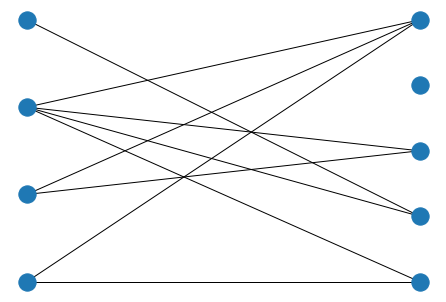

In [15]:
a = np.random.randint(2,6) # Nodes in part A_G
b = np.random.randint(2,6) # Nodes in part B_G
m = np.random.randint(2,6) # Dimension of M

# Generating a random bipartive graph with a + b nodes.
G = bipartite.random_graph(a,b,np.random.rand())

# Generating a Random matrix of size m
M =  np.random.randint(0,3,[m,m]) * np.random.rand(m,m)
print(M)
pos = nx.bipartite_layout(G,set(list(range(a))))
nx.draw(G,pos)

print(hom(G,M))
print(homb(G,M))